# ptt熱門關鍵字

### 簡介

在ptt上的gossiping版上每天都有許多關於目前大家所關注話題的貼文，因此利用ptt上的gossiping版做為了解目前討論趨勢的來源。
透過分析標題的關鍵字，計算2月份中關鍵字出現的次數與對應的推文數，篩選出前5名繪製成直方圖。

### 程式碼撰寫

In [13]:
import requests
from bs4 import BeautifulSoup
import jieba
import datetime

載入繁體中文的斷詞字典

In [14]:
jieba.set_dictionary('/Users/linjiaying/Desktop/ICT-Python-101/data/dict.txt.big')

取得DOM

In [15]:
def fetch(url):
    res = requests.get(url, cookies={'over18': '1'}) #已滿18歲
    soup = BeautifulSoup(res.text ,"html")
    return soup

取得標題、連結、日期、推文數

In [16]:
def get_title(data):
    title_divs = data.select("div.r-ent")
    l = []
    for divs in title_divs:
        a = divs.find('a')
        if not a:
            continue
        try:
            date = divs.select('div.date')[0].text.strip()
            month, day = date.split('/')
            date = datetime.datetime(2024, int(month), int(day))
            push_block = divs.select('div.nrec span')
            push_count = int(push_block[0].text.strip())
            l.append((a.text, 'https://www.ptt.cc'+a['href'], date, push_count))
        except:
            pass
    return l

取得前一頁的網址

In [17]:
def get_prev(data):
    paging_div = data.find('div', 'btn-group btn-group-paging')
    prev_url = 'https://www.ptt.cc' + paging_div.find_all('a')[1]['href']
    return prev_url

取得一段時間內的標題內容

In [18]:
def get_data(start_url, start_date, end_date):
    
    titles = []

    url = start_url
    is_first = True
    
    while True:

        result = fetch(url)
        new_titles = get_title(result)
        
        flag = False
        for new_title in new_titles:
            date = new_title[2]
            if date >= start_date and date <= end_date:
                titles.append(new_title)
            if date >= start_date:
                flag = True
    
        if not is_first and not flag:
            break
            
        url = get_prev(result)
    
        if is_first == True:
            is_first = False

    return titles

關鍵字在一段時間內，每天分別出現的次數

In [19]:
def get_keyword_data(start_url, start_date, end_date, keyword_list):

    url = start_url
    is_first = True

    keyword_data = {}
    for keyword in keyword_list:
        keyword_data[keyword] = {}

    while True:

        result = fetch(url)
        new_titles = get_title(result)

        flag = False
        for new_title in new_titles:
            text = new_title[0]
            date = new_title[2]
            if date >= start_date and date <= end_date:

                date_s = date.strftime("%Y-%m-%d")

                for keyword in keyword_list:
                    if keyword in text:
                        if date_s in keyword_data[keyword]:
                            keyword_data[keyword][date_s] += 1
                        else:
                            keyword_data[keyword][date_s] = 1
                
            if date >= start_date:
                flag = True
    
        if not is_first and not flag:
            break

        url = get_prev(result)

        if is_first:
            is_first = False

    return keyword_data

取得2月份關鍵字的累積出現次數與累積推文數

In [20]:
start_date = datetime.datetime(2024, 2, 1)
end_date = datetime.datetime(2024, 2, 29)
titles = get_data("https://www.ptt.cc/bbs/Gossiping/index.html", start_date, end_date)
keyword = {}
for title in titles:
    text = title[0]
    text_tokenized = list(jieba.cut(text, cut_all=True))
    for v in text_tokenized:
        #只保留長度在2以上的詞
        if len(v) < 2:
            continue
        if v in keyword:
            keyword[v][0] += 1
            keyword[v][1] += title[3]
        else:
            keyword[v] = [1, title[3]]

Building prefix dict from /Users/linjiaying/Desktop/ICT-Python-101/data/dict.txt.big ...
Dumping model to file cache /var/folders/b2/ymyy4n6j7yd170w47snttvs80000gn/T/jieba.ub307f1e8725e845919832b6d5321e60b.cache
Loading model cost 4.210 seconds.
Prefix dict has been built successfully.


In [21]:
keyword_l = list(keyword.items())
keyword_l[:10]

[('21', [44, 661]),
 ('上午', [9, 115]),
 ('桃園', [49, 833]),
 ('南昌', [3, 22]),
 ('街口', [3, 12]),
 ('行車', [19, 90]),
 ('東海', [4, 43]),
 ('東海大學', [1, 21]),
 ('海大', [1, 21]),
 ('大學', [166, 1604])]

依照關鍵字的出現次數排序（由多到少）

In [22]:
keyword_l.sort(key=lambda x: x[1][0], reverse=True)

2月份在標題裡出現的關鍵字中，出現次數最多的前20名

In [23]:
keyword_l[:20]

[('新聞', [7883, 125625]),
 ('Re', [7827, 43308]),
 ('什麼', [3142, 28921]),
 ('怎麼', [1918, 17192]),
 ('不是', [1862, 14889]),
 ('是不是', [1644, 12491]),
 ('沒有', [965, 7456]),
 ('日本', [927, 10741]),
 ('中國', [873, 8929]),
 ('八卦', [867, 6532]),
 ('現在', [799, 6898]),
 ('可以', [767, 7164]),
 ('真的', [626, 6576]),
 ('有沒有', [607, 4200]),
 ('有人', [565, 4647]),
 ('過年', [506, 3271]),
 ('沒人', [488, 4507]),
 ('還是', [485, 4101]),
 ('發現', [460, 4037]),
 ('小雞', [459, 5548])]

2月份在標題裡出現的關鍵字中，累積推文數最多的前20名

In [24]:
keyword_l.sort(key=lambda x: x[1][1], reverse=True)
keyword_l[:20]

[('新聞', [7883, 125625]),
 ('Re', [7827, 43308]),
 ('什麼', [3142, 28921]),
 ('怎麼', [1918, 17192]),
 ('不是', [1862, 14889]),
 ('是不是', [1644, 12491]),
 ('日本', [927, 10741]),
 ('中國', [873, 8929]),
 ('快訊', [357, 8209]),
 ('沒有', [965, 7456]),
 ('可以', [767, 7164]),
 ('現在', [799, 6898]),
 ('真的', [626, 6576]),
 ('八卦', [867, 6532]),
 ('瘦肉', [321, 5593]),
 ('小雞', [459, 5548]),
 ('瘦肉精', [317, 5540]),
 ('韓國', [362, 4661]),
 ('有人', [565, 4647]),
 ('晚安', [343, 4508])]

在2月份關鍵字的出現次數與累積推文數中，發現出現次數與累積推文數呈現一定的正向關係，因此以累積出現次數為依據，選出有意義的前5個關鍵字，並取得這些關鍵字每天分別出現的次數

In [25]:
start_url = "https://www.ptt.cc/bbs/Gossiping/index.html"
start_date = datetime.datetime(2024, 2, 1)
end_date = datetime.datetime(2024, 2, 29)
data = get_keyword_data(start_url, start_date, end_date, ['日本', '中國', '瘦肉', '小雞', '韓國'])

### 繪製成直方圖

In [26]:
import matplotlib.pyplot as plt

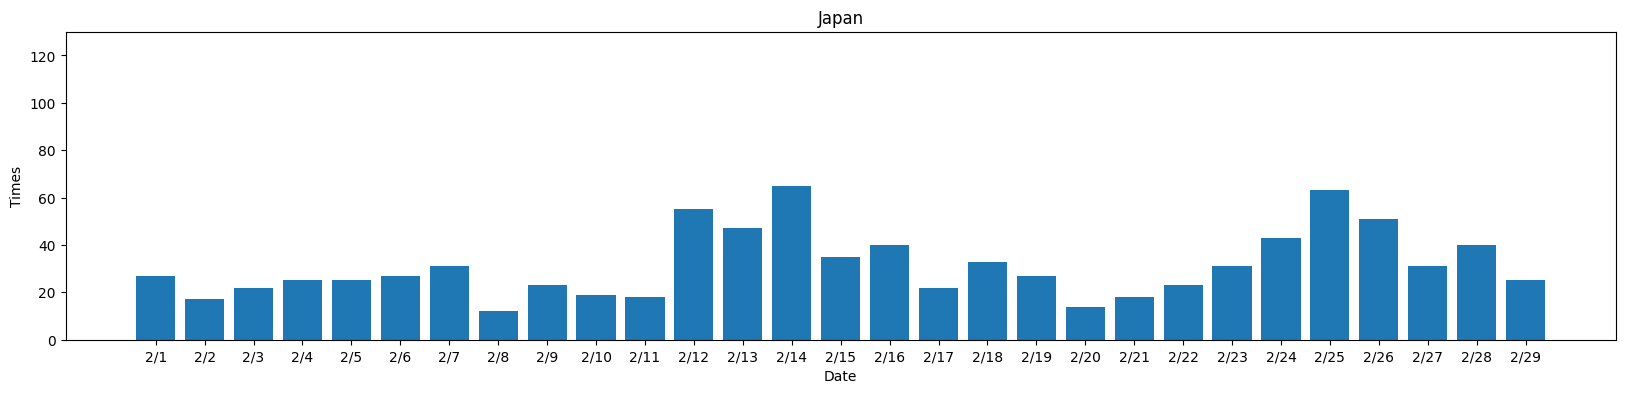

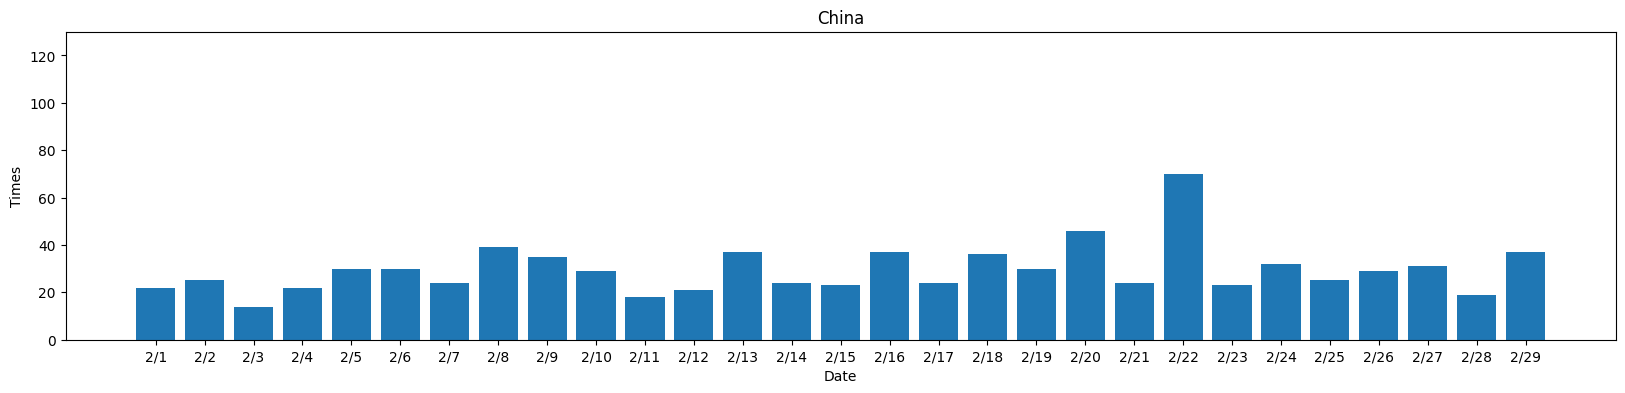

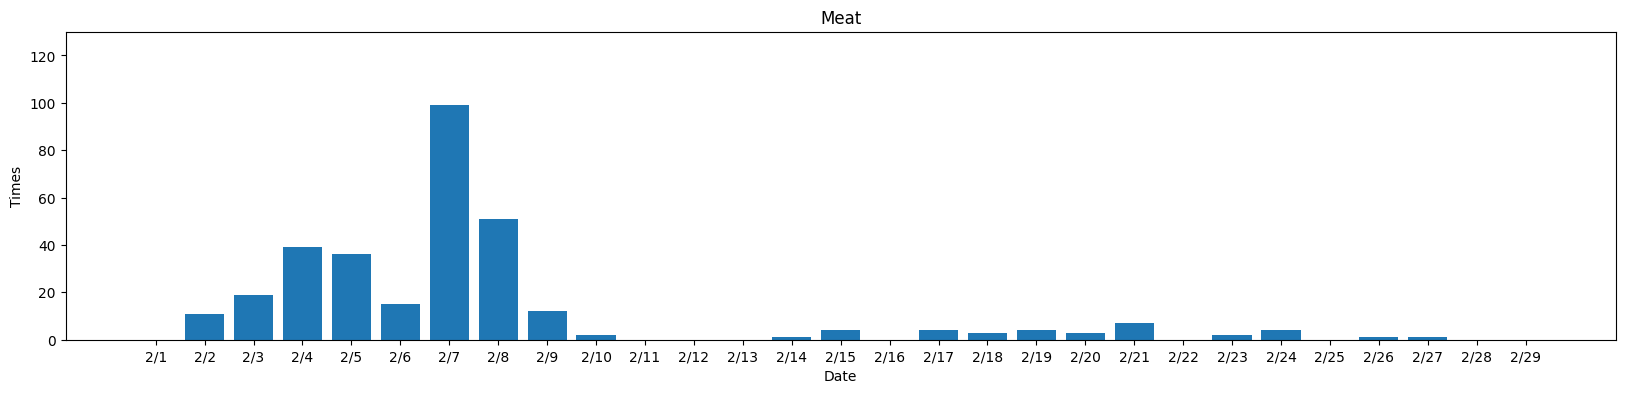

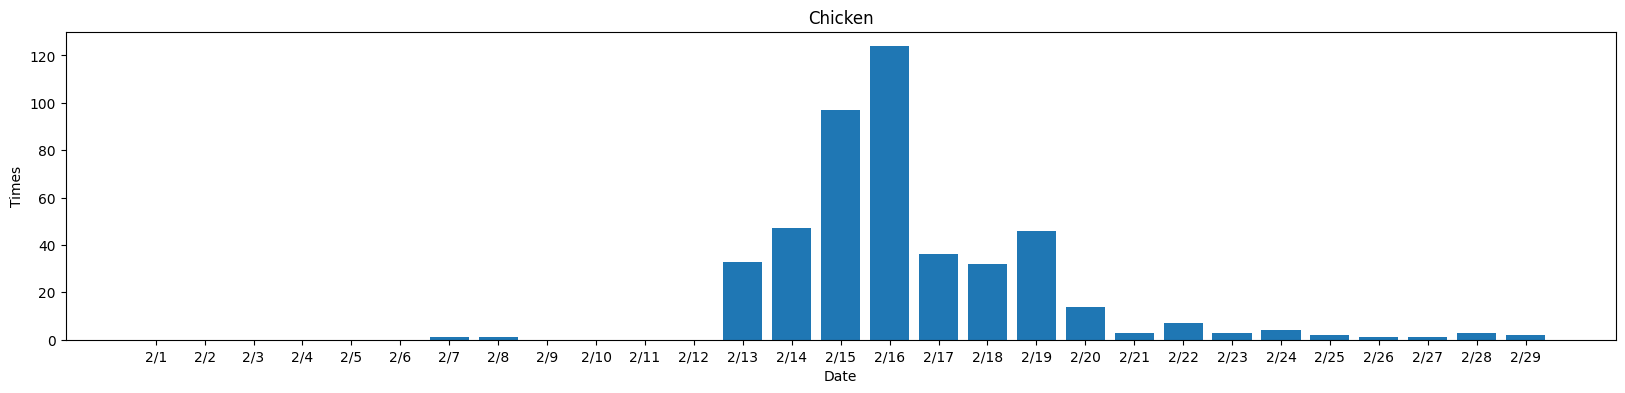

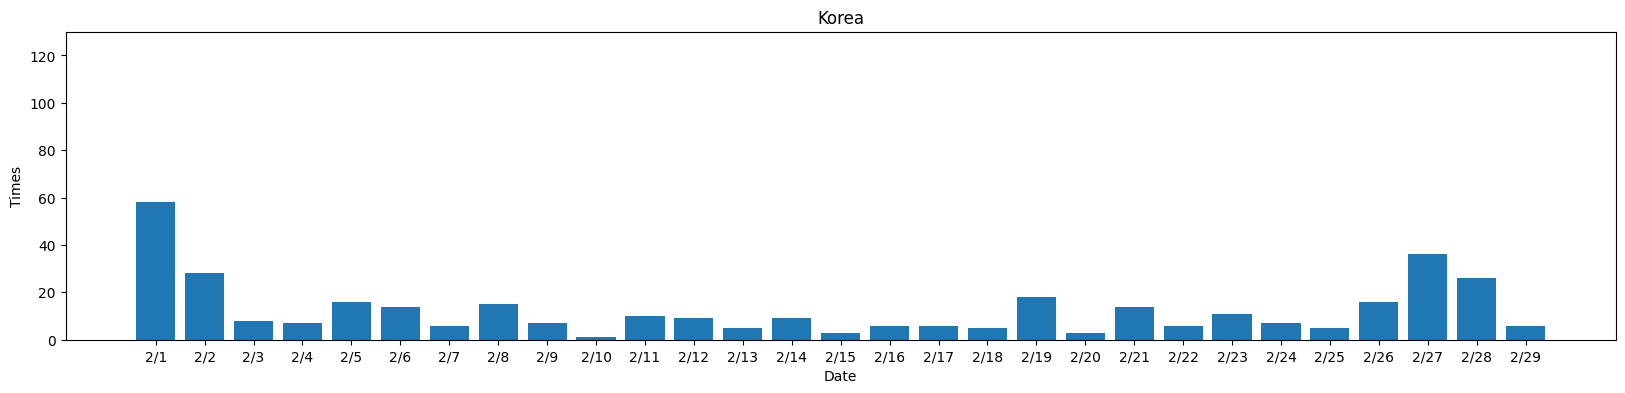

In [27]:
fig_titles = ['Japan', 'China', 'Meat', 'Chicken', 'Korea']
for index, keyword in enumerate(['日本', '中國', '瘦肉', '小雞', '韓國']):
    l = []
    for i in range(1, 30):
        s = '2024-02-' + f'{i:02d}'
        if s in data[keyword]:
            l.append(data[keyword][s])
        else:
            l.append(0)
    plt.figure(figsize=(20, 4))
    plt.bar(list(range(29)), l)
    plt.xticks(list(range(29)), [f'2/{x+1}' for x in range(29)])
    plt.xlabel('Date')
    plt.ylabel('Times')
    plt.ylim(0, 130)
    plt.title(fig_titles[index])
    plt.show()

將結果會製成直方圖，可以看出以下現象：
1. 若是長期關心的議題，每天出現的次數差異不大，例如日本、中國
2. 若是發生某一事件，則會在發生的幾天內有大量的出現次數，但在幾天後立即減少，例如瘦肉、晚安